In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from missforest import MissForest
from scipy.stats import ks_2samp
from sklearn.metrics import mean_absolute_error
import random
from sklearn.impute import KNNImputer

In [24]:
def ks_test_comparison_kde(simulated_data, missF_imputed_data, mean_imputed_data, knn_imputed_data, variables_to_check):
    """
    Perform Kolmogorov-Smirnov (KS) tests comparing data and imputed data (using three methods: MissForest, Mean, KNN).
    Also perform Bonferroni correction and plot the distributions for each method using KDE.

    Parameters:
    - data (pd.DataFrame): The dataset with missing values.
    - missF_imputed_data (pd.DataFrame): The dataset with MissForest imputed values.
    - mean_imputed_data (pd.DataFrame): The dataset with Mean imputed values.
    - knn_imputed_data (pd.DataFrame): The dataset with KNN imputed values.
    - variables_to_check (list): The list of variables (columns) to perform the KS test on.
    """
    
    alpha_originale = 0.05
    alpha_nuovo = alpha_originale / len(variables_to_check)
    
    # Store results for significance checking
    ks_results = {}
    
    # Perform KS tests for each variable and each imputation method
    for variable in variables_to_check:
        
        # Plot distributions for Simulated Data, MissForest, Mean, and KNN using KDE
        plt.figure(figsize=(10, 6))

        # KDE plot for the simulated data
        sns.kdeplot(simulated_data[variable].dropna(), label=f"Simulated {variable}", color='blue', fill=False)
        
        # KDE plot for the imputed data for each method
        sns.kdeplot(missF_imputed_data[variable].dropna(), label=f"MissForest {variable}", color='red', fill=False, alpha=0.5)
        sns.kdeplot(mean_imputed_data[variable].dropna(), label=f"Mean {variable}", color='green', fill=False, alpha=0.5)
        sns.kdeplot(knn_imputed_data[variable].dropna(), label=f"KNN {variable}", color='orange', fill=False, alpha=0.5)

        # Title and labels
        plt.title(f"Distribution of {variable} for Simulated vs Imputed Methods")
        plt.xlabel(variable)
        plt.ylabel('Density')
        plt.legend(loc='upper right')
        plt.show()
        
        # Initialize a dictionary to store p-values
        p_values = {}

        # KS Test for each method (MissForest, Mean, and KNN)
        for method, imputed_data in {'MissForest': missF_imputed_data, 'Mean': mean_imputed_data, 'KNN': knn_imputed_data}.items():
            ks_stat, p_value = ks_2samp(simulated_data[variable].dropna(), imputed_data[variable].dropna())
            p_values[method] = p_value

            # Print KS test results for each method
            print(f"KS Test for {variable} using {method}: KS Statistic = {ks_stat}, p-value = {p_value}")

        # Apply Bonferroni correction for multiple comparisons
        for method, p_value in p_values.items():
            if p_value < alpha_nuovo:
                ks_results[(variable, method)] = "Significant"
                print(f"The result for {variable} using {method} is significant after Bonferroni correction.")
            else:
                ks_results[(variable, method)] = "Not Significant"
                print(f"The result for {variable} using {method} is not significant after Bonferroni correction.")
    
    return ks_results

In [3]:
# Load the dataset
data = pd.read_csv('rad_clin_feats_PFS_OS.csv')

# Explore the data
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Columns: 1146 entries, MPC to wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis
dtypes: float64(1135), int64(2), object(9)
memory usage: 1.9+ MB
None


Count: The number of non-null entries for each column.
Mean: The average value of each column.
Standard Deviation (std): The spread of the data around the mean.
Minimum (min): The smallest value in each column.
25th Percentile (25%): The value below which 25% of the data falls.
Median (50%): The middle value of the data (also known as the 50th percentile).
75th Percentile (75%): The value below which 75% of the data falls.
Maximum (max): The largest value in each column.

In [4]:
data= data.replace('nv', np.nan)

In [5]:
# Identify columns with missing values
missing_columns = data.columns[data.isnull().sum() != 0]

# Print the columns with missing values and their respective counts
for col in missing_columns:
    print(f'{col}: {data[col].isnull().sum()}')
    print(f'{col}: {data[col].describe()}')
    

PLT: 2
PLT: count     219
unique    152
top       227
freq        4
Name: PLT, dtype: object
HB: 2
HB: count      219
unique      80
top       10.8
freq         9
Name: HB, dtype: object
R_ISS: 59
R_ISS: count     162
unique      3
top         2
freq       92
Name: R_ISS, dtype: object
CREATININE: 1
CREATININE: count     220
unique    113
top       0.8
freq        9
Name: CREATININE, dtype: object
Clearence: 159
Clearence: count     62
unique    42
top       90
freq       4
Name: Clearence, dtype: object
PC_TOT: 35
PC_TOT: count     186
unique     20
top        20
freq       30
Name: PC_TOT, dtype: object
CALCIUM: 28
CALCIUM: count     193
unique     41
top       9.7
freq       14
Name: CALCIUM, dtype: object


In [6]:
# Binarize categorical variables
data['SEX'] = data['SEX'].map({'M': 1, 'F': 0})



In [7]:
print(data['SEX'])

0      1
1      1
2      0
3      1
4      0
      ..
216    1
217    1
218    0
219    1
220    1
Name: SEX, Length: 221, dtype: int64


In [8]:
# Converti tutte le colonne in numerico
data = data.apply(pd.to_numeric, errors='coerce')

In [9]:
# Filtra le colonne che hanno valori NaN
columns_with_nan = data.columns[data.isna().any()].tolist()

# Conta il numero totale di valori NaN e calcola la percentuale di valori NaN per ogni colonna con NaN
nan_counts = data[columns_with_nan].isna().sum()
nan_percentages = (nan_counts / data.shape[0]) * 100

# Stampa i risultati
for col in columns_with_nan:
    print(f"Colonna: {col}")
    print(f"Total NaN Count: {nan_counts[col]}")
    print(f"Total NaN Percentage: {nan_percentages[col]:.2f}%\n")

Colonna: MPC
Total NaN Count: 221
Total NaN Percentage: 100.00%

Colonna: PLT
Total NaN Count: 2
Total NaN Percentage: 0.90%

Colonna: HB
Total NaN Count: 2
Total NaN Percentage: 0.90%

Colonna: R_ISS
Total NaN Count: 59
Total NaN Percentage: 26.70%

Colonna: CREATININE
Total NaN Count: 1
Total NaN Percentage: 0.45%

Colonna: Clearence
Total NaN Count: 159
Total NaN Percentage: 71.95%

Colonna: PC_TOT
Total NaN Count: 35
Total NaN Percentage: 15.84%

Colonna: CALCIUM
Total NaN Count: 28
Total NaN Percentage: 12.67%



In [10]:
# Rimotion of 'MPC' column because there are the identification number of the patient, not useful for my analysis
data = data.drop(columns= ['MPC'])
data = data.drop(columns= ['Clearence'])

In [11]:
# Conta il numero totale di valori NaN nel dataset
total_nan_count = data.isna().sum().sum()

# Calcola la percentuale di valori NaN nel dataset
total_nan_percentage = (total_nan_count / data.size) * 100

print(f"Total NaN Count: {total_nan_count}")
print(f"Total NaN Percentage: {total_nan_percentage:.2f}%")


Total NaN Count: 127
Total NaN Percentage: 0.05%


In [12]:
# Function to identify categorical variables with values 0 or 1
def find_binary_categorical_vars(df):
    binary_categorical_vars = []
    for col in df.columns:
        if df[col].dropna().isin([0, 1]).all():
            binary_categorical_vars.append(col)
    return binary_categorical_vars

# Identify binary categorical variables
binary_categorical_vars = find_binary_categorical_vars(data)

print("Categorical variables with values 0 or 1 are:", binary_categorical_vars)

Categorical variables with values 0 or 1 are: ['PFS_I_EVENT', 'OS_EVENT', 'SEX']


In [13]:
# Split dataset into train and test sets.
train, test = train_test_split(data, test_size=.3, shuffle=True,
                               random_state=42)

# Default estimators are lgbm classifier and regressor
mf = MissForest()
mf.fit(
    x=train,
    categorical=["PFS_I_EVENT", "OS_EVENT", "SEX"]
)
train_imputed = mf.transform(x=train)
test_imputed = mf.transform(x=test)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.35it/s]


In [19]:
# Unisci i due dataframe mantenendo gli indici originali
imputed_data = pd.concat([train_imputed, test_imputed])

# Ordina gli indici in ordine crescente
missF_imputed_data = imputed_data.sort_index()



In [20]:
missF_imputed_data.to_csv('imputed_data.csv', index=False)

In [21]:
# Replace NaN values with the mean of each column
mean_imputed_data = data.fillna(data.mean())


In [22]:
# Replace NaN values with the KNN method
k = 5  # Choose the number of neighbors
knn_imputer = KNNImputer(n_neighbors=k, weights='distance')

#Fit and transform the data to replace NaNs
knn_imputed_data = pd.DataFrame(knn_imputer.fit_transform(data), columns=data.columns)



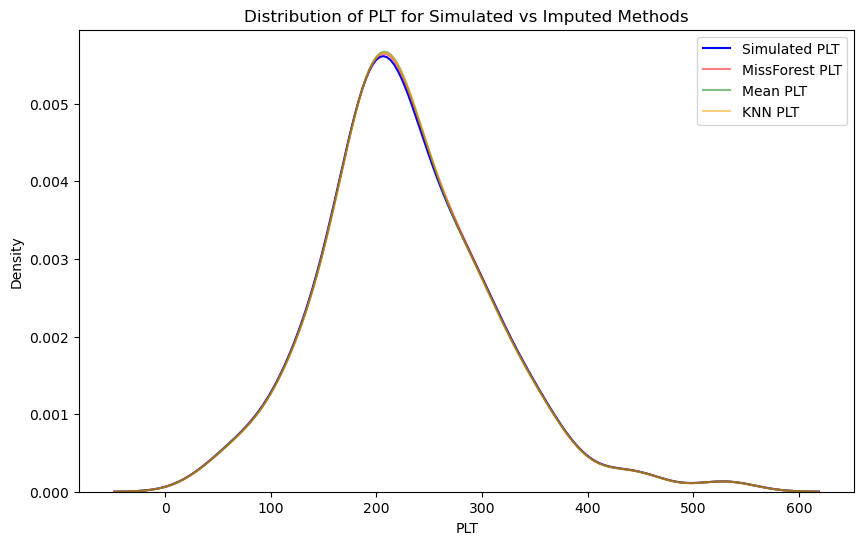

KS Test for PLT using MissForest: KS Statistic = 0.004586871629579123, p-value = 1.0
KS Test for PLT using Mean: KS Statistic = 0.005082749643587677, p-value = 1.0
KS Test for PLT using KNN: KS Statistic = 0.005206719147089816, p-value = 1.0
The result for PLT using MissForest is not significant after Bonferroni correction.
The result for PLT using Mean is not significant after Bonferroni correction.
The result for PLT using KNN is not significant after Bonferroni correction.


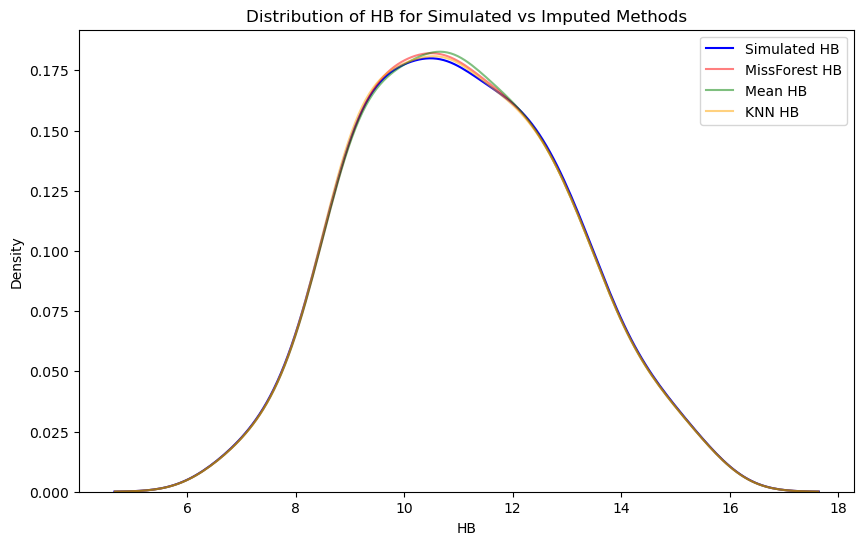

KS Test for HB using MissForest: KS Statistic = 0.004214963119072708, p-value = 1.0
KS Test for HB using Mean: KS Statistic = 0.004752164300915308, p-value = 1.0
KS Test for HB using KNN: KS Statistic = 0.004462902126076985, p-value = 1.0
The result for HB using MissForest is not significant after Bonferroni correction.
The result for HB using Mean is not significant after Bonferroni correction.
The result for HB using KNN is not significant after Bonferroni correction.


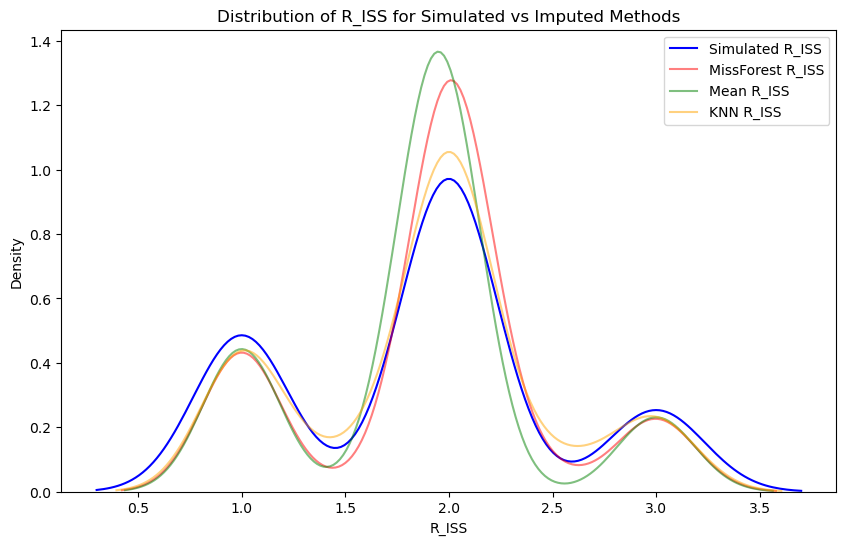

KS Test for R_ISS using MissForest: KS Statistic = 0.13239483827719123, p-value = 0.06697834097298215
KS Test for R_ISS using Mean: KS Statistic = 0.19116250488799508, p-value = 0.0017759853049977555
KS Test for R_ISS using KNN: KS Statistic = 0.09167085637673873, p-value = 0.38136809734675464
The result for R_ISS using MissForest is not significant after Bonferroni correction.
The result for R_ISS using Mean is significant after Bonferroni correction.
The result for R_ISS using KNN is not significant after Bonferroni correction.


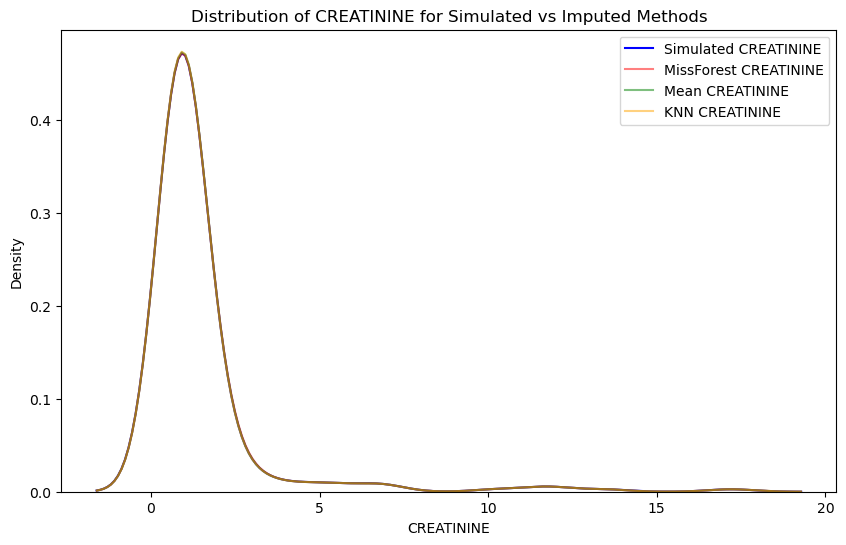

KS Test for CREATININE using MissForest: KS Statistic = 0.004072398190045249, p-value = 1.0
KS Test for CREATININE using Mean: KS Statistic = 0.0037844508432743726, p-value = 1.0
KS Test for CREATININE using KNN: KS Statistic = 0.0035170711641299875, p-value = 1.0
The result for CREATININE using MissForest is not significant after Bonferroni correction.
The result for CREATININE using Mean is not significant after Bonferroni correction.
The result for CREATININE using KNN is not significant after Bonferroni correction.


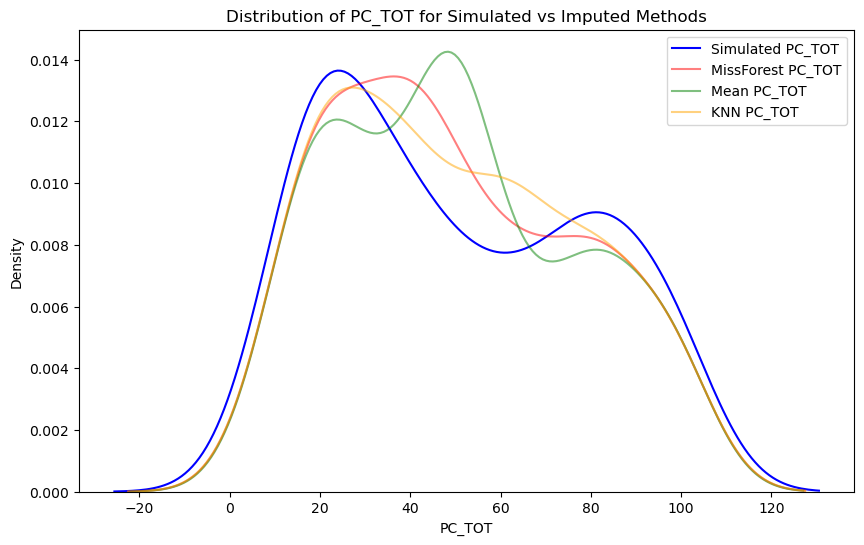

KS Test for PC_TOT using MissForest: KS Statistic = 0.056512431275239625, p-value = 0.8787338120736229
KS Test for PC_TOT using Mean: KS Statistic = 0.09195737848489272, p-value = 0.3333399039206373
KS Test for PC_TOT using KNN: KS Statistic = 0.060453461781735024, p-value = 0.8244795909791254
The result for PC_TOT using MissForest is not significant after Bonferroni correction.
The result for PC_TOT using Mean is not significant after Bonferroni correction.
The result for PC_TOT using KNN is not significant after Bonferroni correction.


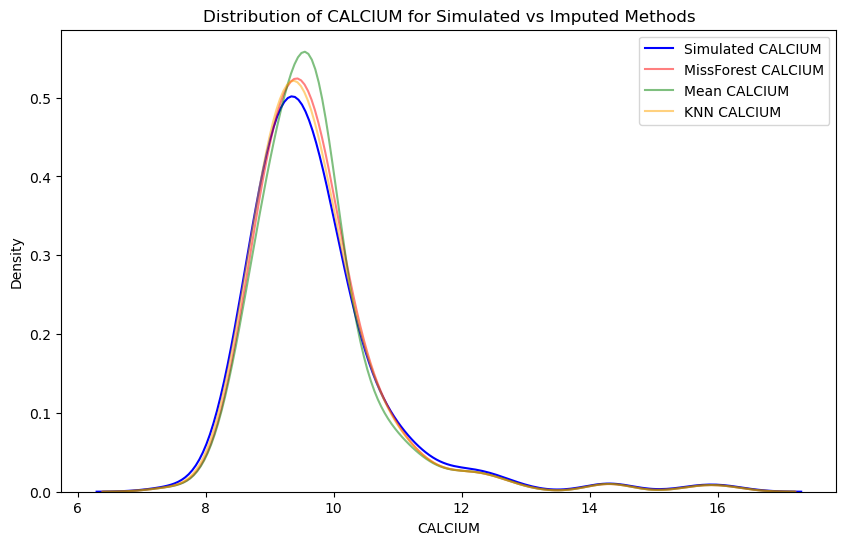

KS Test for CALCIUM using MissForest: KS Statistic = 0.0345579443415469, p-value = 0.9991305705724972
KS Test for CALCIUM using Mean: KS Statistic = 0.08337045459873865, p-value = 0.43939080420321075
KS Test for CALCIUM using KNN: KS Statistic = 0.02098328370806274, p-value = 0.9999999986718252
The result for CALCIUM using MissForest is not significant after Bonferroni correction.
The result for CALCIUM using Mean is not significant after Bonferroni correction.
The result for CALCIUM using KNN is not significant after Bonferroni correction.


In [25]:
# - data: The dataset with missing values
# - missF_imputed_data: The dataset with MissForest imputed values
# - mean_imputed_data: The dataset with Mean imputed values
# - knn_imputed_data: The dataset with KNN imputed values
# - variables_to_check: A list of variables (columns) to test

variables_to_check = ['PLT', 'HB', 'R_ISS', 'CREATININE', 'PC_TOT', 'CALCIUM'] # Replace with your actual variable names

ks_results = ks_test_comparison_kde(data, missF_imputed_data, mean_imputed_data, knn_imputed_data, variables_to_check)


In [26]:
# Set a random seed for reproducibility
np.random.seed(42)  # Use any integer to set the seed

# Get missing counts per column in the original data
original_missing_counts = data.isna().sum()
simulated_data = imputed_data.copy()

# Apply the same missing count to each variable in the simulated dataset
for column, missing_count in original_missing_counts.items():
    if missing_count > 0:
        # Randomly choose indices to set as NaN
        random_indices = np.random.choice(simulated_data.index, missing_count, replace=False)
        simulated_data.loc[random_indices, column] = np.nan

print(simulated_data)


     PFS_I_EVENT  PFS_I_MONTHS  OS_EVENT  OS_MONTH    PLT    HB   AGE  \
65             0          24.0         0      24.0  301.0  13.6  66.0   
112            1          23.0         1      41.0  118.0   8.9  71.0   
186            1          40.0         0      90.0  243.0   8.9  49.0   
155            1          43.0         0      87.0  256.0  10.5  62.0   
31             0          12.0         0      12.0  237.0  12.5  58.0   
..           ...           ...       ...       ...    ...   ...   ...   
139            0          10.0         0      10.0  144.0  14.6  45.0   
56             0          22.0         0      22.0  243.0  12.4  49.0   
156            1          46.0         1      74.0  165.0  13.2  51.0   
176            1          35.0         0      47.0  228.0  10.7  59.0   
163            1          78.0         0      88.0  251.0  12.5  57.0   

        R_ISS  SEX  CREATININE  ...  wavelet-LLL_gldm_GrayLevelNonUniformity  \
65   2.000000    0        0.52  ...        

In [27]:
simulated_data.to_csv('simulated_data.csv', index=False)


In [28]:
# Identify columns with missing values
missing_columns = simulated_data.columns[simulated_data.isnull().sum() != 0]

# Print the columns with missing values and their respective counts
for col in missing_columns:
    print(f'{col}: {simulated_data[col].isnull().sum()}')
    print(f'{col}: {simulated_data[col].describe()}')


PLT: 2
PLT: count    219.000000
mean     227.202141
std       78.554941
min       35.000000
25%      181.000000
50%      217.000000
75%      274.000000
max      536.000000
Name: PLT, dtype: float64
HB: 2
HB: count    219.000000
mean      11.040051
std        1.901930
min        6.600000
25%        9.600000
50%       10.800000
75%       12.400000
max       15.700000
Name: HB, dtype: float64
R_ISS: 59
R_ISS: count    162.000000
mean       1.904796
std        0.561705
min        1.000000
25%        1.865933
50%        2.000000
75%        2.046537
max        3.000000
Name: R_ISS, dtype: float64
CREATININE: 1
CREATININE: count    220.000000
mean       1.474499
std        2.041233
min        0.470000
25%        0.740000
50%        0.920000
75%        1.262500
max       17.200000
Name: CREATININE, dtype: float64
PC_TOT: 35
PC_TOT: count    186.000000
mean      49.647976
std       26.292859
min       10.000000
25%       30.000000
50%       44.387694
75%       70.000000
max      100.000000
Name

In [29]:
# Split dataset into train and test sets.
train_simulated_data, test_simulated_data = train_test_split(simulated_data, test_size=.3, shuffle=True,
                               random_state=42)

# Default estimators are lgbm classifier and regressor
mf = MissForest()
mf.fit(
    x=train_simulated_data,
    categorical=["PFS_I_EVENT", "OS_EVENT", "SEX"]
)
train_imputed_missing = mf.transform(x=train_simulated_data)
test_imputed_missing = mf.transform(x=test_simulated_data)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


In [35]:
# Unisci i due dataframe mantenendo gli indici originali
imputed_simulated_data = pd.concat([train_imputed_missing, test_imputed_missing])

# Ordina gli indici in ordine crescente
imputed_simulated_data = imputed_simulated_data.sort_index()


0      258.217649
1      202.203580
2      294.000000
3      275.000000
4      227.000000
          ...    
216    289.000000
217     69.000000
218    241.000000
219    281.000000
220    114.000000
Name: PLT, Length: 221, dtype: float64


In [31]:
imputed_simulated_data.to_csv('missF_imputed_simulated_data.csv', index=False)

In [32]:
# Replace NaN values with the mean of each column
mean_imputed_simulated_data = simulated_data.fillna(data.mean())
mean_imputed_simulated_data.to_csv('mean_imputed_simulated_data.csv', index=False)

In [33]:
#Initialize the KNN imputer with the desired number of neighbors
k = 5  # Choose the number of neighbors
knn_imputer = KNNImputer(n_neighbors=k, weights='distance')

#Fit and transform the data to replace NaNs
knn_imputed_simulated_data = pd.DataFrame(knn_imputer.fit_transform(simulated_data), columns=simulated_data.columns)


In [34]:
knn_imputed_simulated_data.to_csv('knn_imputed_simulated_data.csv', index=False)